# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

## Set-up environment

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ! unzip "/content/drive/MyDrive/Colab Notebooks/gul-ahmed-data.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/gul-ahmed-data.zip
   creating: gul-ahmed-data/
  inflating: gul-ahmed-data/gul_ahmed_metadata.csv  
   creating: gul-ahmed-data/images/
  inflating: gul-ahmed-data/images/image0.jpg  
  inflating: gul-ahmed-data/images/image1.jpg  
  inflating: gul-ahmed-data/images/image10.jpg  
  inflating: gul-ahmed-data/images/image100.jpg  
  inflating: gul-ahmed-data/images/image1000.jpg  
  inflating: gul-ahmed-data/images/image1001.jpg  
  inflating: gul-ahmed-data/images/image1002.jpg  
  inflating: gul-ahmed-data/images/image1003.jpg  
  inflating: gul-ahmed-data/images/image1004.jpg  
  inflating: gul-ahmed-data/images/image1005.jpg  
  inflating: gul-ahmed-data/images/image1006.jpg  
  inflating: gul-ahmed-data/images/image1007.jpg  
  inflating: gul-ahmed-data/images/image1008.jpg  
  inflating: gul-ahmed-data/images/image1009.jpg  
  inflating: gul-ahmed-data/images/image101.jpg  
  inflating: gul-ahmed-data/images/image1010.jpg  
  inflat

In [ ]:
# !pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [4]:
from datasets import Dataset
import pandas as pd
from PIL import Image
import os

# Paths
image_folder = "gul-ahmed-data/images"
metadata_csv = "gul-ahmed-data/gul_ahmed_metadata.csv"

# Load the metadata
metadata = pd.read_csv(metadata_csv)

# Filter metadata to keep only rows with non-empty descriptions
metadata = metadata.dropna(subset=["Description"]).reset_index(drop=True)
metadata = metadata[metadata["Description"].str.strip() != ""].reset_index(drop=True)

# Define a function to load images
def load_image(example):
    image_path = os.path.join(image_folder, example["Image Filename"])
    example["image"] = Image.open(image_path).convert("RGB")  # Ensure RGB format
    return example

# Convert the metadata into a Hugging Face dataset
dataset = Dataset.from_pandas(metadata)

# Add the images to the dataset
dataset = dataset.map(load_image)

# Example usage: Accessing an image and its metadata
print(dataset[0])  # Access the first sample


Map:   0%|          | 0/1161 [00:00<?, ? examples/s]

{'Product ID': 0, 'Product Title': 'Darcy Unstitched Fabric Blended with Gift Box', 'Brand': 'Gul Ahmed', 'Image Filename': 'image0.jpg', 'Image Path': './gul-ahmed-data/images/image0.jpg', 'Image URL': 'https://www.gulahmedshop.com/media/catalog/product/d/a/darcy_unstitched_fabric_blended_with_gift_box-black_3_.jpg?optimize=medium&auto=webp&bg-color=255,255,255&fit=bounds&canvas=2:3&width=450&height=675', 'Product URL': 'https://www.gulahmedshop.com/darcy-unstitched-fabric-blended-with-gift-box', 'Description': 'Craft your wardrobe essentials with the finest fabrics from GulAhmed Men’s Collection, offering unmatched quality and style.', 'Additional Info': "{'Color:': 'Black', 'Product Type:': '2 Piece', 'Gender:': 'Men', 'Discount Percentage:': '31% to 40%', 'Shirt Fabric:': 'Wash & Wear'}", 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=450x675 at 0x7AE5C83F3E80>}


In [5]:
from datasets import DatasetDict

# Split your dataset
split_dataset = dataset.train_test_split(test_size=0.2)

# Convert to DatasetDict for ease of use
dataset_dict = DatasetDict({
    "train": split_dataset["train"],
    "test": split_dataset["test"]
})

print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['Product ID', 'Product Title', 'Brand', 'Image Filename', 'Image Path', 'Image URL', 'Product URL', 'Description', 'Additional Info', 'image'],
        num_rows: 928
    })
    test: Dataset({
        features: ['Product ID', 'Product Title', 'Brand', 'Image Filename', 'Image Path', 'Image URL', 'Product URL', 'Description', 'Additional Info', 'image'],
        num_rows: 233
    })
})


Let's retrieve the caption of the first example:

In [7]:
dataset_dict["train"][50]["Description"]

'Top your traditional wear with an exquisite waistcoat from Ideas.'

And the corresponding image

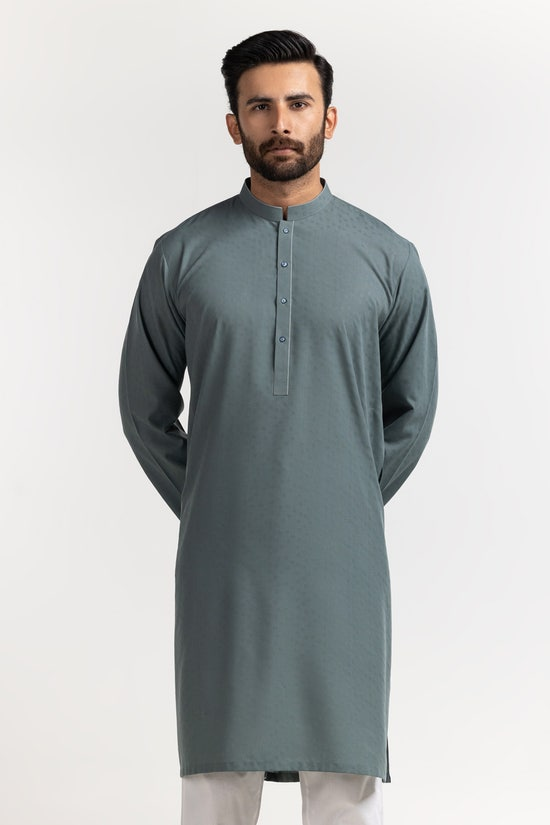

In [8]:
dataset_dict["train"][500]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [9]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["Description"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [10]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [11]:
train_dataset = ImageCaptioningDataset(dataset_dict["train"], processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [12]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(5):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 13.010787010192871
Loss: 10.092862129211426
Loss: 10.121245384216309
Loss: 10.113304138183594
Loss: 10.122832298278809
Loss: 9.992862701416016
Loss: 10.189980506896973
Loss: 10.054239273071289
Loss: 10.016318321228027
Loss: 9.851702690124512
Loss: 10.095888137817383
Loss: 9.981237411499023
Loss: 10.084224700927734
Loss: 10.030342102050781
Loss: 9.755971908569336
Loss: 9.808975219726562
Loss: 9.86815357208252
Loss: 9.821813583374023
Loss: 9.91573429107666
Loss: 9.605020523071289
Loss: 9.927289009094238
Loss: 9.136781692504883
Loss: 8.943002700805664
Loss: 8.672384262084961
Loss: 8.511068344116211
Loss: 8.276390075683594
Loss: 8.129294395446777
Loss: 7.771906852722168
Loss: 7.644041061401367
Loss: 7.4557061195373535
Loss: 7.204874038696289
Loss: 6.967971324920654
Loss: 6.838129043579102
Loss: 6.593735218048096
Loss: 6.453358173370361
Loss: 6.3352532386779785
Loss: 6.163747787475586
Loss: 5.992380619049072
Loss: 5.870175838470459
Loss: 5.730259895324707
Loss: 5.66264533996582
Loss: 

## Save Model

In [33]:
# Directory to save the model
save_directory = "/content/drive/MyDrive/Colab Notebooks/trained_blip_model"

# Save the model and tokenizer
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)

print(f"Model saved to {save_directory}")


Model saved to /content/drive/MyDrive/Colab Notebooks/trained_blip_model


## Model Loading

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load the model and processor
load_directory = "/content/drive/MyDrive/Colab Notebooks/trained_blip_model"
processor = BlipProcessor.from_pretrained(load_directory)
model = BlipForConditionalGeneration.from_pretrained(load_directory)

print("Model and processor loaded successfully.")


## Inference

Let's check the results on our train dataset

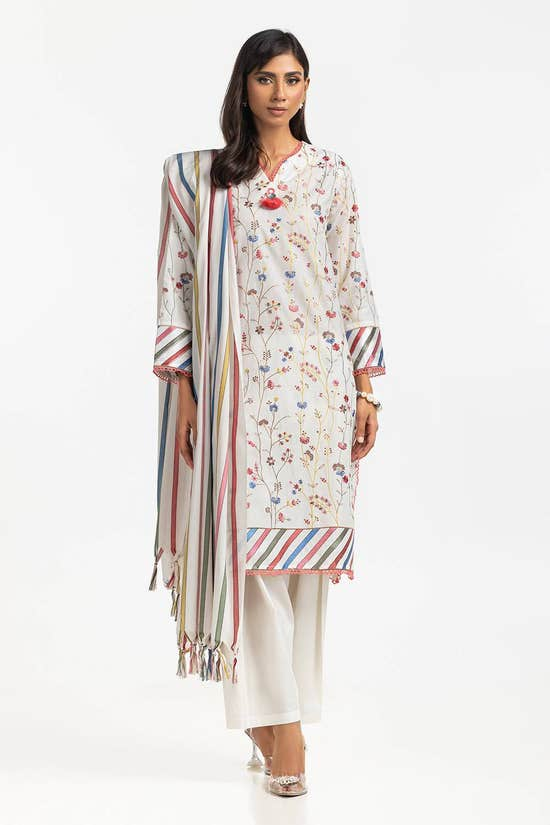

In [30]:
# load image
example = dataset_dict["test"][154]
text = example["Description"]
image = example["image"]
image

In [31]:
print(text)

Ready to wear This 3PC off white outfit is embellished with delicate white embroidery. The matching dupatta complements the design, making it a versatile choice for both casual and formal wear.


In [32]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

ready to wear this 3pc white ensemble features delicate white embroidery, creating a delicate look. with its delicate design, making it an ideal choice for festive gatherings and celebrations.


Let's check the results on our train dataset!

In [34]:
import pandas as pd
from tqdm import tqdm  # For progress bar

# Initialize a list to store results
results = []

# Set model to evaluation mode
model.eval()

# Iterate over the test set
for example in tqdm(dataset_dict["test"]):
    original_description = example["Description"]  # Original description
    image = example["image"]  # Image

    # Prepare the image for the model
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    # Generate caption
    with torch.no_grad():
        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        predicted_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Store the results
    results.append({
        "Original Description": original_description,
        "Predicted Caption": predicted_caption
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save to a CSV file
results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/trained_blip_results.csv", index=False)

print("Results saved to test_results.csv")


100%|██████████| 233/233 [02:24<00:00,  1.62it/s]

Results saved to test_results.csv
